In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

In [2]:
df= pd.read_csv("genomic.Ecoli.gff.txt", delimiter='\t', on_bad_lines='skip', skiprows = range(0,7), usecols= [2,3,4,8])
df = df.rename(columns={"region": "type", '1': 'start', '4641652': 'end', "ID=NC_000913.3:1..4641652;Dbxref=taxon:511145;Is_circular=true;Name=ANONYMOUS;gbkey=Src;genome=chromosome;mol_type=genomic DNA;strain=K-12;substrain=MG1655": "ID"})

geni_df = df[df['type'] == 'gene'].copy()
geni_df

#geni_df['Gene_ID'] = geni_df['ID'].str.extract(r'gene-(\w+)')
#geni_df
geni_df.loc[:, 'Gene_ID'] = geni_df['ID'].str.extract(r'gene-(\w+)')

table = geni_df.drop(columns=[geni_df.columns[0], geni_df.columns[3]])

In [3]:
lista_geni = pd.read_csv("numbering_assembly-tfs-enzymes-genes.txt", delimiter='\t', header=None)
lista_geni.columns = ['n', 'name', 'code']

clean = table[table["Gene_ID"].isin(lista_geni["name"])].copy()

tot_length = 4641628
ori_s= 3925744	
ori_e= 3925975

gap= tot_length - ori_s
print (gap)
#clean is the name of 1st task

def transpose(row, x):
    if row[x] > ori_s:
        return row[x] - (tot_length - gap)
    else:
        return row[x] + gap

clean.loc[:,'x0'] = clean.apply(transpose, args=("start",), axis=1)
clean.loc[:,'xf'] = clean.apply(transpose, args=("end",), axis=1)
clean.loc[:, 'mean_length'] = clean[['xf', 'x0']].mean(axis=1)

#convert to rad 
clean.loc[:,"rad"] = clean["mean_length"] * 2*np.pi / tot_length
clean.head()
#clean.tail(50)

715884


,start,end,Gene_ID,x0,xf,mean_length,rad
0,190.0,255.0,b0001,716074.0,716139.0,716106.5,0.969365
2,337.0,2799.0,b0002,716221.0,718683.0,717452.0,0.971186
4,2801.0,3733.0,b0003,718685.0,719617.0,719151.0,0.973486
6,3734.0,5020.0,b0004,719618.0,720904.0,720261.0,0.974988
8,5234.0,5530.0,b0005,721118.0,721414.0,721266.0,0.976349


In [4]:
#2pi = circle/ genome. 3,14*2=6.28+1 = 64
#useful cluster to reduce noise (cut makes cluster)

bins = np.linspace(0, tot_length, 64)
labels = np.arange(0,len(bins)-1).astype(str)

clean.loc[:, 'window'] = pd.cut(clean['mean_length'], bins = bins, labels = labels)

In [5]:
express_ds= pd.read_csv("numbering_assembly-tfs-enzymes-genes.txt", delimiter='\t', header=None) #perfettooo
express_ds.columns= ["index", "gene", "gname"]
#express_ds

In [6]:
df_mix = pd.merge(clean, express_ds, left_on='Gene_ID', right_on='gene', how='inner')
df_mix
compared = df_mix.iloc[:, -3:]
compared 
#risultato = compared[compared["index"] == 1]
#risultato

,index,gene,gname
0,1682,b0001,thrL
1,329,b0002,thrA
2,330,b0003,thrB
3,331,b0004,thrC
4,1683,b0005,yaaX
...,...,...,...
4008,4178,b4399,creC
4009,4179,b4400,creD
4010,322,b4401,arcA
4011,4180,b4402,yjjY


In [244]:
activity= pd.read_csv("Ecoli-compendium-assembly-quantilenorm.txt", header=None) #perfettooo
activity.columns= ["gene expression"]

def mean(row):
    valori = [float(x) for x in row.split('\t')]  
    return np.mean(valori) 

activity['<gene expression>'] = activity['gene expression'].apply(mean)
activity['Index'] = activity.index
activity ['Index'] += 1 
activity

,gene expression,<gene expression>,Index
0,8.9866\t8.96573\t9.16509\t9.91827\t9.31151\t9....,9.476333,1
1,7.67516\t7.32882\t9.23499\t9.08551\t7.824\t8.0...,8.665976,2
2,7.5142\t7.72284\t8.60211\t8.60835\t8.99406\t9....,8.649849,3
3,9.36543\t9.2822\t9.2524\t9.42441\t9.64057\t9.3...,8.221497,4
4,7.72137\t7.14853\t7.54841\t8.05535\t7.46411\t7...,7.593446,5
...,...,...,...
4184,7.15116\t6.96303\t6.67086\t6.81146\t6.90408\t6...,7.795246,4185
4185,10.0202\t10.0579\t9.27833\t9.89407\t8.8061\t9....,9.568801,4186
4186,8.27591\t8.60992\t8.90958\t8.6037\t8.90214\t8....,9.008062,4187
4187,9.78257\t9.40689\t9.60678\t9.91933\t9.62006\t9...,9.552222,4188


In [246]:
final_df = pd.merge(compared, activity, left_on= "index", right_on="Index", how='inner')

to_use = final_df.iloc[:,[0,1,4]]

###  ! FINAL !
to_plot = pd.merge(to_use, clean[['Gene_ID', 'window', "rad"]], left_on="gene", right_on= 'Gene_ID')
to_plot
'''
#plot rad over expression for single gene
to_plot['rad'] = to_plot['rad'].astype(float)
plt.figure(figsize=(10, 7))
plt.scatter(to_plot["rad"], to_use["<gene expression>"])
plt.title("overall gene expressione")
plt.xlabel("all gene")
plt.ylabel("gene expression")

plt.show()
'''

,index,gene,<gene expression>,Gene_ID,window,rad
0,1682,b0001,8.955559,b0001,9,0.969365
1,329,b0002,10.635098,b0002,9,0.971186
2,330,b0003,10.052047,b0003,9,0.973486
3,331,b0004,10.309146,b0004,9,0.974988
4,1683,b0005,8.951732,b0005,9,0.976349
...,...,...,...,...,...,...
4008,4178,b4399,8.573345,b4399,9,0.963351
4009,4179,b4400,8.335789,b4400,9,0.965308
4010,322,b4401,11.063333,b4401,9,0.966789
4011,4180,b4402,8.019629,b4402,9,0.967499


In [9]:
super = to_plot.groupby('window', observed= False).agg({'<gene expression>': 'mean'})
super.columns.tolist()
df.reset_index(inplace=True)
'''
plt.plot(super.index, super["<gene expression>"])
plt.xticks (np.linspace(0, 65, 20), rotation=45)
plt.title("<gene expression> over clusters")
plt.xlabel("cluster")
plt.ylabel("mean gene expressione")

plt.show()
'''

'\nplt.plot(super.index, super["<gene expression>"])\nplt.xticks (np.linspace(0, 65, 20), rotation=45)\nplt.title("<gene expression> over clusters")\nplt.xlabel("cluster")\nplt.ylabel("mean gene expressione")\n\nplt.show()\n'

In [10]:
#try to clean
'''
plt.boxplot(super["<gene expression>"])
plt.show()   

Q1 = super.groupby('window', observed= False)['<gene expression>'].quantile(0.25)
Q3 = super.groupby('window', observed= False)['<gene expression>'].quantile(0.75)

# Calcola l'intervallo interquartile (IQR) per ogni finestra
IQR = Q3 - Q1

# Definisci i limiti inferiore e superiore per identificare gli outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filtra il DataFrame per includere solo i valori che non sono considerati outliers
cleaned_super = super[(super['<gene expression>'] >= lower_limit) & (super['<gene expression>'] <= upper_limit)]
'''

'\nplt.boxplot(super["<gene expression>"])\nplt.show()   \n\nQ1 = super.groupby(\'window\', observed= False)[\'<gene expression>\'].quantile(0.25)\nQ3 = super.groupby(\'window\', observed= False)[\'<gene expression>\'].quantile(0.75)\n\n# Calcola l\'intervallo interquartile (IQR) per ogni finestra\nIQR = Q3 - Q1\n\n# Definisci i limiti inferiore e superiore per identificare gli outliers\nlower_limit = Q1 - 1.5 * IQR\nupper_limit = Q3 + 1.5 * IQR\n\n# Filtra il DataFrame per includere solo i valori che non sono considerati outliers\ncleaned_super = super[(super[\'<gene expression>\'] >= lower_limit) & (super[\'<gene expression>\'] <= upper_limit)]\n'

In [11]:
super["window"] = super.index
super["window"] = pd.to_numeric(super["window"], errors='coerce')
super['rad'] = super["window"]/10
super["cos"] = super["rad"].apply(np.cos)
super

,<gene expression>,window,rad,cos
window,,,,
0,9.746930,0,0.0,1.000000
1,9.304414,1,0.1,0.995004
2,9.354917,2,0.2,0.980067
3,9.838797,3,0.3,0.955336
4,9.067037,4,0.4,0.921061
...,...,...,...,...
58,9.288046,58,5.8,0.885520
59,9.181001,59,5.9,0.927478
60,8.897875,60,6.0,0.960170


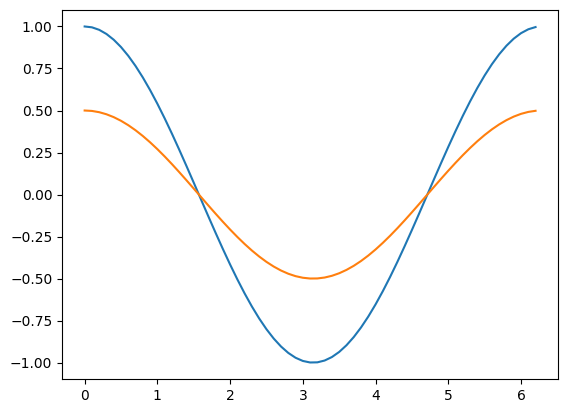

In [295]:
plt.plot(super["rad"], super["cos"])
plt.plot(super["rad"], super["cos"]*0.5)
plt.show()

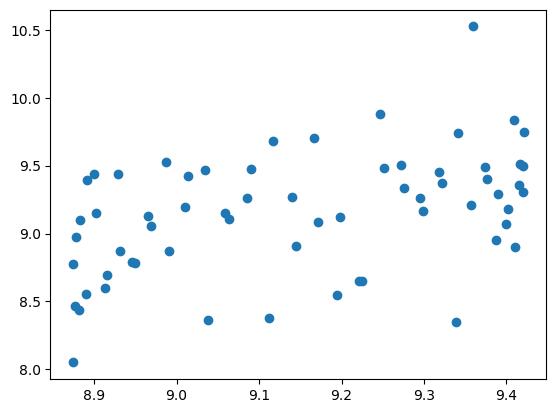

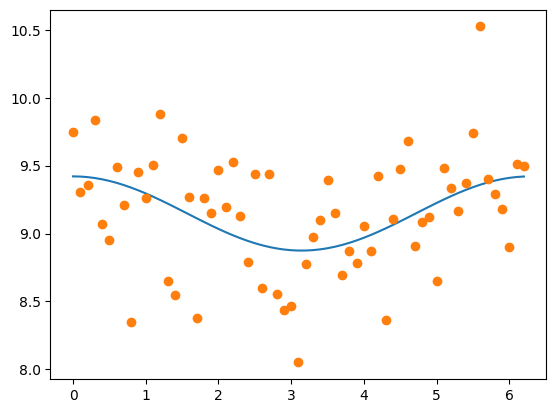

In [283]:
x= pd.DataFrame(data=super, columns= ["cos"])
model = LinearRegression().fit(x, super["<gene expression>"])
model.coef_
model.intercept_
model.predict(x)  #y value
model.score(x,  super["<gene expression>"])
prex= model.predict(x)

plt.plot(prex, super["<gene expression>"], linestyle= "none", marker= 'o')
plt.show()
plt.plot(super["rad"], prex)
plt.plot(super["rad"], super["<gene expression>"], linestyle= "none", marker= 'o')
plt.show()


9.147717829813933 0.2734424752208221


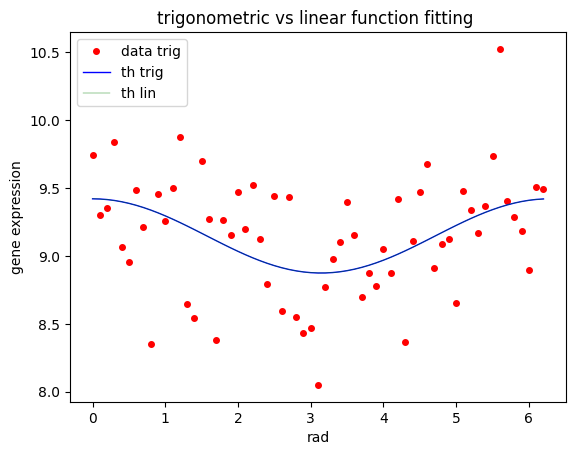

In [307]:
def fit_fun(x,a,b):
    y= a+ b*np.cos(x)
    return y
    
popt,pcov=curve_fit(fit_fun,super["rad"],super["<gene expression>"]) 
print(*popt)
perr=np.sqrt(np.diag(pcov))

plt.plot(super["rad"],super["<gene expression>"], color='red', label='data trig',marker='o',markersize=4, linestyle="none")
plt.plot(super["rad"], fit_fun(super["rad"], *popt),color='blue',lw=1, label="th trig")
plt.plot(super["rad"], prex, label="th lin", lw=0.3, color="green")
plt.legend()
plt.title("trigonometric vs linear function fitting ")
plt.xlabel("rad")
plt.ylabel("gene expression")
plt.show()

#save paramters
#y= alph find!!

In [14]:
repliche= pd.read_csv("DataSetS1_CarreraAnnotations.txt", delimiter='\t', usecols= [0, 12])
repliche.head()

,Column array (EcoMAC),Replicate
0,590,r1
1,591,r2
2,592,r3
3,593,r1
4,594,r2


In [15]:
#just to check the length
gene_ex= "8.9866 8.96573	9.16509	9.91827	9.31151	9.06478	8.82719	8.83624	9.79437	10.1564	8.91841	9.15758	9.31151	9.30762	8.84377	8.55237	8.87008	8.62564	9.54624	9.30997	8.63488	8.51612	9.0737	9.08255	8.52657	8.50713	9.0246	9.03578	9.00899	8.62793	9.44867	9.44047	9.47834	9.52593	8.92889	9.29754	9.3395	8.88052	8.68429	8.60292	9.03207	8.92815	8.73506	9.14862	8.99406	8.55396	8.75857	8.58964	8.77139	8.9251	8.33285	8.7556	8.86783	8.78427	8.84911	8.84911	8.64847	9.08845	9.09812	8.91326	8.914	10.8982	9.7336	8.88872	8.97244	8.62248	8.56189	8.49247	8.74424	8.47263	8.88201	8.66356	8.63255	8.4331	8.43818	8.56898	8.59521	8.41425	8.71238	8.77215	9.06998	8.88201	10.1244	9.92148	9.30374	8.94843	9.28758	8.71088	8.76012	8.47263	8.69566	9.11075	9.24554	8.7343	8.75711	8.70257	8.67124	8.99701	8.80987	9.18013	8.65041	8.96341	8.85364	8.84833	8.87678	8.96948	8.69566	8.92889	8.54762	8.75786	8.94691	8.91104	8.79567	8.99777	8.80685	8.81062	8.90585	8.93036	10.5606	11.0676	11.2878	9.72506	10.9235	10.7587	10.5338	10.6618	9.82013	11.0784	10.5206	11.0206	9.67135	9.44047	9.97354	9.56071	9.00528	9.06109	10.0777	10.2514	9.10037	9.31851	9.0944	9.11678	9.52003	9.28991	9.06626	9.42356	9.43325	10.0452	9.38757	8.95072	8.89838	8.97469	9.75837	10.0954	10.2289	9.26613	9.38281	9.53102	9.43727	9.42763	9.41722	9.65402	9.68698	9.39238	9.0685	9.66047	9.68147	9.5403	9.59107	9.35517	9.46102	9.64861	9.66587	9.55733	9.70736	9.73457	9.45692	9.45527	9.0907	9.46597	10.1076	9.88261	10.1391	9.69342	9.16432	9.39403	9.5902	9.12638	9.39484	9.42763	9.3789	9.41168	9.08107	9.5183	8.56032	9.36467	9.32948	9.3789	8.86558	9.19215	9.46352	9.45938	9.038	9.69992	9.41004	10.199	9.66678	9.00972	9.78257	9.79537	9.02012	9.01564	9.13236	9.84336	9.55479	9.66403	9.74978	9.94638	9.70736	9.81513	9.43885	9.75837	9.80717	9.67046	9.77385	9.39725	9.64952	9.71294	9.74123	9.78161	9.72133	9.67225	9.55216	9.98684	9.52766	9.46514	9.58233	9.66768	9.73071	9.71857	9.43885	9.83827	9.0974	9.43162	9.8013	9.75361	9.85261	9.6962	9.78355	9.81317	8.88277	9.33795	9.77676	9.85157	9.5268	9.69714	9.66952	8.7752	9.4421	9.52087	9.2524	9.55305	9.80717	9.79336	9.90147	9.74028	9.31151	9.6459	9.78941	8.8204	9.68053	9.78645	9.62978	9.64496	9.6343	9.4586	9.39886	9.73836	9.42763	9.77676	9.91299	9.69806	9.68973	9.72971	9.88674	9.43484	9.6787	9.75646	9.6343	9.61651	9.59461	9.73262	9.64143	9.72784	9.22517	9.64952	9.10337	9.53186	8.99701	9.61916	9.71765	9.60678	9.48907	9.769	10.0871	10.269	9.94526	9.46269	9.55987	9.8211	9.62888	9.46678	9.64861	9.18541	9.61207	9.69898	9.19587	9.31539	9.54624	9.7336	9.40769	9.69342	9.70927	9.6423	9.61563	9.78941	9.58065	9.74214	9.69068	9.73262	9.62092	9.49153	9.56071	9.17337	9.7083	8.55796	8.97987	8.45678	8.97691	9.41409	9.43082	9.09888	8.66893	8.98961	8.58492	8.9221	8.95822	8.91989	8.85138	9.7336	9.09362	9.72692	9.32005	9.02912	8.94994	8.69948	9.91191	9.71294	9.95184	9.92789	10.1927	10.25	8.88277	8.58806	8.7661	10.1416	9.77385	10.0293	9.98902	9.98902	10.0372	9.77964	10.4354	10.2826	9.06626	8.851	8.39427	8.95295	8.79788	8.80165	8.78579	9.38679	9.04251	8.7541	8.74271	8.64425	8.89838	9.08845	9.29677	9.33104	9.39725	8.68351	9.24554	8.91766	8.99631	9.11075	8.83851	9.34423	9.39565	8.92436	8.84304	9.15758	8.79788	8.80241	9.22064	8.82117	8.66742	9.41409	8.98439	8.70027	8.75933	9.06924	9.28991	8.84004	9.48	9.29754	9.084	8.62008	7.71853	8.69341	8.86783	8.94691	9.06033	9.0164	8.71464	8.45593	8.64035	8.86935	8.81892	8.94691	8.71391	8.83025	9.72692	8.97691	9.82717	9.93988	9.96041	9.97354	8.50878	8.86111	7.86386	8.06115	9.59282	10.3782	10.0731	10.1889	10.0871	9.73071	8.65041	8.45762	9.01116	9.16432	8.80761	9.07513	9.01042	8.78807	8.32639	8.7616	8.76086	7.96382	8.88872	8.97244	8.62248	8.72374	8.5753	8.37939	8.56189	8.49247	8.74424	9.25161	9.13457	9.09961	8.23577	8.53145	7.81999	8.6949	8.7616	8.87603	8.22862	8.35012	8.04253	8.70105	8.2027	8.25747	8.76685	8.38378	7.87766	7.8042	8.92436	8.40199	8.59827	8.81134	8.54998	8.72074	8.49007	8.64885	8.4551	8.64348	8.94093	8.80536	9.30144	9.64952	10.144	9.41568	9.88777	9.34423	8.84451	9.00225	8.35104	8.51448	8.78654	8.4314	8.53228	8.23777	8.30522	8.43902	8.27877	8.79864	8.4793	8.26721	7.73865	8.24581	8.29014	8.3644	8.11151	9.5505	9.86275	9.77483	10.165	8.50878	9.03426	9.08551	10.2487	9.11002	9.50157	9.70178	9.72599	9.34499	8.70181	8.67277	8.77215	9.15608	8.92889	9.02538	8.82194	8.87532	8.9522	9.06261	8.89539	9.39643	9.36862	7.99533	9.13677	8.99107	8.93337	9.09588	9.21012	9.32478	8.94468	9.53862	9.5565	9.14718	9.10115	8.54276	9.14128	8.99107	8.59368	9.17937	8.2623	8.59207	8.64117	8.0869	8.31911	8.55873	8.82342	8.58331	8.75786	9.81017	10.3156	10.1293	10.1404	9.09665	9.04769	9.30762	8.66819	8.54922	9.49072	9.05997	8.53308	8.8939	8.94616	9.08628	8.77897	8.78882	8.63416	8.79036	8.7343	8.83552	9.32239	9.13828	9.06626	8.89094	8.96341	9.05813	9.05141	8.98215	9.07589	8.7661	8.76538	8.69416	9.09665	9.31306	8.83025	8.75711	8.97542	8.72679	9.25693	8.94691	8.88052	8.89727	9.11075	8.84377	8.84004	9.09888	8.93337	8.94093	9.07884	9.03063	8.94994	8.90958	8.97023	8.93413	8.66666	8.41162	8.75933	8.57453	8.30799	8.3108	8.53713	8.54114	8.91621	9.0223	8.42877	8.51448	8.83475	8.83176	8.91033	9.24174	9.42763	9.5268	9.21012	9.04324	10.0384	9.16211	8.61228	8.89094	8.51531	8.47681	9.54072	9.07811	9.07956	8.54922	8.87828	9.0974	8.54193	8.94168	8.86339	9.27909	10.0124	9.06261	8.44242	9.39643	8.92436	9.14645	8.49902	8.62564	8.54998	8.48666	8.80987	8.42962	8.42449	8.67047	9.03877	8.87383	8.382	8.71998	8.85288	8.77061	8.64656	8.85364	8.93489	9.20633	8.84077	8.85211	9.52932	9.22064	9.45938	8.99182	8.83775	9.30842	8.80908	9.43966	9.1538	8.66356	8.87828	8.54998	9.45692	9.6334	9.39238	9.59981	9.82313	9.72133	10.0202	9.88154	8.34014	8.4551	8.35639	8.37678	8.8204	8.08171	9.16062	8.02774	9.20187	8.33744	8.41425	8.34289	8.01696	8.837	8.54998	10.2093	10.0719	8.7473	8.77973	9.03504	9.09142	9.01864	8.80091	8.84004	9.48	9.29754	9.084	8.62008	7.71853	8.69341	8.86783	8.94691	9.06033	9.0164	8.71464	8.45593	8.64035	8.86935	8.81892	8.94691	8.71391	8.23982	8.55553	8.60992	8.6543	8.2565	8.74655	8.59046	8.71464	8.59207	8.82194	8.93715	8.83401	9.18165	9.01116	8.93111	9.18915	8.73056	9.22367	9.09588	8.99999	8.96193	9.04026	9.06261	8.80685	8.87008	9.12862	9.05884	9.0149	9.1197	9.29911	9.53186	9.20787	9.37809	9.34895	9.37575	9.00378	9.15758	9.0223	9.43966	9.72506	9.1869	8.95295	9.05848	9.01116	9.0744	9.17036	9.09362	9.43242	9.20936	9.36467	8.67583	9.05361	9.11678	9.33104	9.18088	9.24857	9.07884	9.28837	9.038	9.23203	9.00753	9.2822	7.61484	8.49166	8.8136	9.40368	9.30071	8.37678	8.89764	8.62008	8.50307	8.12499	7.88506	9.13382	9.16357	8.86111	8.91693	9.1869	8.87532	8.2141	8.71998	7.95878	8.7503	8.55715	9.11157	9.12936	9.99229	10.628	8.68193	9.43082	10.199	9.41722	9.54285	9.69992	9.49153	8.96193	9.7459	9.52426	9.65587	9.8993	8.29766	8.60211	8.70257	8.3024	8.39775	8.80761	8.90807	8.58011	8.79187	8.89169	8.55237	9.08183	8.04672	8.846	9.06109	9.99894	11.3079	11.1537	10.7082	10.7549	10.5929	10.6051	10.7973	10.1539	10.49	9.87738	9.93988	10.5124	11.0649	11.0206	10.2662	9.86904	10.199	10.4384	10.008	9.81616	9.98132	10.5338	10.3752	10.7254	8.66435	8.62167	9.14423	8.99037	9.32871	9.30997	8.72074	9.1538	8.99182	9.03877	7.81999	8.75105	8.4826	8.27492	8.01318	8.44578	9.04543	9.10412	9.41086	9.38915	9.32555	9.68698	8.68193	9.37025	9.37809	9.49576	9.36622	9.14274	9.72413	8.39427	8.70782	8.89169	8.88574	8.58649	8.93792	10.3323	8.89169	8.94168	9.37495	9.07737	9.33104	9.47045	8.47013	8.48426	8.22451	9.08183	8.54922	9.13604	8.92286	9.19066	9.35287	8.63569	9.71294	8.75484	8.43902	8.785	8.57135	8.67583	8.37238	7.59384	9.45692	9.2116	8.7616	8.97691	7.48573	8.38908	8.51859	8.46843	8.2816	8.44495	8.88426	8.50713	8.7473	8.52738	8.83251	8.70636	8.54276	8.64578	8.49498	8.58725	8.48666	8.66515	8.54034	8.24284	8.67047	8.60135	8.65811	8.56583	8.64578	8.37059	8.15771	9.00972	10.2003	9.02309	8.10851	8.37148	8.65041	9.14423	9.13604	9.30071	9.1869	9.09665	10.3198	8.42962	8.95971	9.01716	9.03281	8.968	8.52984	8.59754	8.97469	8.65272	8.50796	8.66356	9.32401	9.23499	8.82342	9.01716	8.74047	8.62008	8.50388	8.56504	8.34379	8.23373	8.69643	9.09888	8.65888	8.85586	8.72679	8.45848	8.66043	8.44578	8.47765	9.0596	8.91473	9.17716	8.86262	9.08551	9.16736	8.66515	8.61228	8.85439	8.57851	8.58492	8.6827	9.5234	8.35814	8.73279	8.7556	9.15457	9.25315	9.64861	9.88674	9.91933	10.0012	8.77751	8.93865	8.61774	8.37678	8.92659	8.67507	9.26923	9.05216	9.33872	9.00675	9.38679	8.61695	9.05736	8.84451	9.08326	8.67353	8.7949	9.08107	10.2315	8.7298	7.67664	9.53186	9.28758	8.41857	8.94616	9.5972	8.48176	9.53862	9.64143	9.71949	9.14423	8.56423	9.09812	9.1249	9.69342	9.16886	10.5124	8.93792	9.08183	10.165	9.6343	9.32794	8.82418	8.47598	8.38991	8.71088	9.15086	8.2565	8.76912	9.38281	8.86186	8.77289	9.27305	8.56741	8.80241	8.61303	9.06777	8.87532	9.19887	8.8061	9.40447	8.98138	9.18242	8.97469	8.96724	9.28916	8.85288	8.67353	8.52097	8.65888	8.50307	9.03654	9.07663	8.80834	8.82642	9.08995	9.02612	9.2433	8.62793	8.93638	8.846	8.93939	8.80091	8.8061	8.87086	8.92889	9.04618	8.73356	9.25315	9.70736	9.12266	9.78257	9.29219	9.30071	9.17337	9.28837	8.60601	8.7994	9.05658	8.90065	9.142	9.19812	9.36622	9.03063	8.77366	8.81514	9.00602	9.35363	9.26457	9.20787	9.43565	9.21308	8.76384	8.7752	8.88127	8.46927	9.20633	8.84077	8.85211	9.52932	9.22064	9.45938	8.80908	9.43966	9.1538	9.6334	9.59981	9.82313	9.72133	10.0202	9.88154	8.37678	8.8204	8.08171	8.99182	8.83775	9.30842	8.66356	8.87828	8.54998	8.34014	8.4551	8.35639	9.16062	8.02774	9.20187	9.62755	9.41568	9.54197	9.27228	9.12824	9.27305	9.00452	9.17791	9.32794	9.34029	9.38201	9.81815	10.2421	9.84544	9.68422	9.70268	9.32794	10.1183	9.60854	9.21725	10.5589	10.4291	10.4199	10.6297	10.4664	9.78941	10.1099	10.0191	10.4806	11.1421	11.1477	11.0596	11.3944	10.1737	10.3767	10.5929	10.0001	9.61472	9.70365	9.52254	9.55733	9.58065	9.39403	9.23576	9.45527	9.34818	9.32634	9.30144	9.37736	9.6033	9.8211	9.66316	9.75266	9.62618	9.68332	9.62618	10.4139	9.65771	9.39075	9.34499	9.82209	9.27909	9.34423	10.5623	10.8118	10.4664	11.0333	10.4822	9.41487	9.72599	9.14789	9.31617	9.64952	9.50655	9.45116	9.64861	9.24026	9.2937	9.33718	9.06109	9.084	9.68791	8.97318	9.26613	9.5234	10.104	10.0742	9.97026	10.2067	10.1712	10.0057	10.175	9.89621	10.4539	10.4477	9.65131	9.85157	9.70083	9.63252	9.60415	9.69527	9.71949	10.9281	10.4139	10.4493	10.4384	12.0711	12.0339	6.55406	7.37193	7.10007	6.95338	7.48951	7.36641	7.58398	7.45486	10.4139	10.5504	8.98138	8.98061	8.7896	9.20861	9.08551	9.13677	9.53186	9.66952	10.1135	10.3106	9.53441	9.57889	10.3651	10.2554	9.19737	9.75122	8.69149	10.9421	9.22822	8.95748	10.457	11.114	9.92471	9.86377	11.0892	10.6227	11.8838	11.3394	10.1964	11.4059	10.3622	10.3031	9.53862	9.54624	9.53692	9.7884	9.66403	9.769	9.1869	9.23351	9.20633	9.43162	9.32081	9.30531	9.83115	9.53609	9.72599	10.1489	9.93988	10.2145	9.36703	10.1725	9.43565	10.0001	10.2315	9.94311	9.70736	9.75169	10.0812	10.5623	9.52426	9.77241	9.88463	9.86588	11.2452	10.9905	11.4488	11.192	11.4695	9.95073	10.2487	11.4944	11.0436	11.4569	11.5424	10.2758	7.73721	7.49334	7.77873	7.67807	9.83321	10.6968	10.0384	9.73167	10.3045	9.77871	10.008	10.4995	10.1839	9.84649	10.5011	10.5222	9.8607	9.74028	9.91722	9.76617	9.86377	9.82313	9.80524	10.1293	10.0765	9.95622	10.1135	9.92579	9.30919	9.48	9.54875	9.37178	9.56333	9.53355	9.31539	9.49242	9.38679	9.37966	9.25996	9.34107	10.4932	10.4369	10.1737	10.2527	10.3239	10.254	10.2758	10.2866	10.4539	10.1601	10.2514	10.2568	10.3352	10.3593	10.4774	10.2785	10.3113	10.3239	9.92148	9.87944	9.81416	9.98574	10.0179	10.008	9.50034	9.65221	9.45032	9.42602	9.37178	9.35247	9.38515	9.28991	9.40286	10.0789	10.0614	9.9388	9.82313	9.77676	9.92148	9.63699	9.49993	9.46102	9.74781	9.83017	9.7288	9.92579	9.72322	9.43082	10.0696	9.92042	9.5565	9.53186	10.2731	10.4018	9.51918	9.46433	10.2329	10.1159	9.81215	9.57889	10.0591	10.1305	9.29065	9.13084	9.25693	9.73262	9.74497	9.79636	9.6334	9.76126	9.76223	10.2132	10.0731	10.0441	9.30531	9.42602	9.21837	9.75933	9.39238	9.9004	9.72413	10.1003	9.37575	9.79537	9.8993	9.92525	9.15236	9.09588	9.1123	9.26229	9.08326	9.03355	9.26845	9.14128	9.17188	9.14938	9.0246	9.2305	9.35755	9.27228	11.574	10.8544	10.0168	9.91933	10.4079	11.3012	10.9027	10.3409	10.1111	10.8846	9.62006	10.5108	10.2054	10.3338	9.30997	9.33795	9.77289	9.48656	9.71673	9.54709	9.58233	9.57018	9.63296	9.74684	9.69251	10.4822	9.41568	9.30762	9.31696	9.26845	9.98902	9.74978	9.15985	9.19364	9.2305	9.1219	9.22896	9.1353	9.55733	9.49911	9.52171	10.1257	9.93337	10.8201	10.3113	10.6875	10.0685	10.4199	10.2448	9.96041	10.3254	10.3225	10.2368	10.1964	10.0091	10.0614	9.16736	9.11606	9.08697	9.04618	9.00301	9.12786	9.038	9.03504	9.21988	9.39805	9.22517	9.26381	9.44782	9.85362	9.73071	9.87319	9.87107	9.99447	9.59282	9.85761	9.59196	9.77483	10.1864	10.0213	10.1342	9.85659	9.95935	9.81017	9.10856	9.03728	8.99927	9.42602	9.43162	9.41568	9.54961	9.71485	9.63609	10.1016	9.9551	10.0282	7.07378	7.33336	7.31258	7.75689	9.86485	9.41252	10.1123	10.2949	11.9028	12.0264	10.5999	10.6709	11.0462	11.2388	10.4446	9.59461	10.3338	9.32871	8.31726	8.90214	8.72754	10.9711	10.2276	9.78063	9.60155	8.81964	9.01564	9.64772	9.46514	9.60502	9.54542	9.58065	9.75169	9.67593	9.81017	9.68053	9.89407	9.73457	9.53018	9.56333	9.68698	9.4586	9.45609	9.2524	9.142	8.71238	9.18616	9.3318	9.25996	9.51407	9.51154	9.6033	9.72229	9.63699	9.52254	9.68053	9.72599	9.69898	9.67135	9.57798	9.64143	9.37337	9.49242	9.37337	9.2738	9.40689	9.40527	10.8307	10.669	10.6351	9.83522	10.4048	10.3782	10.2608	10.0954	10.0327	10.3017	11.3012	10.0499	10.1147	11.114	10.9166	11.67	10.2473	10.0626	10.2527	10.4585	11.9766	11.5512	11.0892	9.83522	10.3536	10.8004	9.12936	9.51239	10.8139	10.9212	9.90882	9.96259	9.92258	10.1927	10.1589	10.0023	9.26381	9.25161	9.0551	9.26533	9.06109	9.33795	9.21086	9.17566	9.11606	9.22665	9.17188	9.09215	9.21988	9.15236	9.22517	9.01412	9.31151	9.32714	9.11678	9.41004	9.30222	9.31696	9.21764	9.27305	9.26457	8.93715	9.26533	9.20787	9.32555	9.32794	9.09362	9.28529	9.21385	9.24933	9.80524	9.7336	9.56071	9.88777	9.1914	9.68698	9.5234	9.75169	9.85863	9.96146	9.75266	10.9074	10.2341	7.66583	8.3108	7.87525	7.74709	7.93872	8.23931	10.0754	10.3767	10.4033	10.3694	10.3607	10.7607	10.85	10.8244	10.6457	10.5222	10.4727	10.5895	10.6968	10.2949	10.4916	10.4853	10.7411	10.6333	10.6528	10.621	9.39967	9.00899	8.97542	9.14496	9.09888	9.09888	9.08921	9.06549	9.26153	9.10558	9.08845	9.14789	9.07956	9.06261	9.05584	9.04844	9.18915	9.04991	9.09288	9.17414	8.85513	8.99558	8.98365	8.97654	8.98738	8.98886	9.04251	9.00301	11.3045	9.90253	9.57101	11.2979	10.3086	10.4307	10.6931	10.905	11.6019	10.9686	10.5288	10.5895	11.2292	11.5468	12.0949	9.06626	8.8136	8.86935	9.06071	9.10632	9.11822	10.3003	10.9686	9.81513	9.77002	9.7083	10.0102	10.0418	9.9648	9.06184	9.04618	9.08769	9.10558	9.0974	9.06184	9.02912	8.98512	8.95072	8.99258	8.98061	8.98439	8.9221	8.94168	8.95672	8.99777	8.98439	9.08439	9.01864	8.99777	9.04395	8.99406	8.968	9.00378	8.93111	8.95072	9.06333	9.00753	9.03578	8.97839	9.05289	9.07144	9.04251	9.05584	9.0829	9.03207	9.06333	9.07811	9.04102	9.03877	9.08845	9.06626	9.05361	8.99182	9.07513	9.03504	9.02309	9.08032	9.05435	9.0246	9.04991	9.04026	9.02089	9.06478	9.07589	9.08769	9.1538	9.05813	8.99258	9.05813	9.22822	9.29448	9.41168	9.3544	9.26613	9.31617	9.35679	9.3138	11.8901	11.6801	11.1861	11.0029	12.2351	11.192	12.0339	11.2979	11.871	11.841	12.1515	11.3721	10.0091	10.7708	11.5205	11.6601	10.7549	9.96919	10.1552	10.1839	10.3184	10.3031	10.8544	10.4524	10.5206	10.5572	10.3709	9.81914	10.4555	9.95728	10.2907	10.7667	10.816	10.8201	10.1064	10.2262	10.7101	10.4885	10.2771	10.5371	10.4853	10.506	10.9589	10.0719	10.4979	10.4477	10.4759	10.3254	10.4477	10.6166	10.669	10.6672	10.8959	10.6745	10.5028	10.7063	10.9444	10.2935	10.2354	10.381	9.85659	10.1712	10.1813	10.1674	10.4601	10.0836	10.3323	10.25	10.3508	10.1318	10.4155	10.3452	10.3323	10.6837	10.6368	10.4291	10.6457	10.1391	10.3636	10.7994	10.7489	10.4276	10.7063	10.905	10.6988	10.4727	10.4524	10.3184	10.5861	10.6351	10.5912	10.2448	10.1826	9.96812	10.8695	10.6618	10.8393	10.5724	10.2473	10.1977	10.2434	9.79636	10.3579	10.2394	10.4461	10.2581	10.3825	9.76223	10.17	10.2158	10.4885	9.99783	9.87319	10.7352	9.91827	10.2785	10.4048	10.0917	10.423	10.299	10.3198	10.1147	10.669	10.3839	10.3141	10.3254	9.7336	9.97579	10.4585	10.5255	10.5255	10.5206	10.2354	9.93012	10.0661	9.71391	10.3156	10.0942	10.0327	10.3636	10.4461	9.9769	10.6931	10.423	10.5471	10.6017	10.4033	9.86588	10.0327	9.99783	9.66495	10.0191	10.3072	9.95289	10.2648	10.6421	10.0708	10.4916	10.008	10.1952	9.83017	10.2554	10.2047	10.6949	10.783	10.7159	10.6263	10.5707	10.2962	10.1003	10.3508	10.4822	10.669	10.5999	10.2172	10.8824	10.7508	10.6618	11.0397	10.8846	10.9212	10.4727	10.6875	10.6174	10.8478	10.5572	10.9304	10.7391	11.3536	11.1507	10.3796	10.4124	11.0436	10.0871	10.7469	11.2012	10.935	10.7025	10.9638	10.7749	11.1477	11.3646	10.2675	11.1816	10.779	10.0661	10.3973	10.2003	10.0069	10.6245	10.4555	10.8522	10.6837	10.1404	10.0545	10.6912	10.9783	10.8914	11.0258	11.5338	10.3113	10.0638	10.7607	9.98788	9.93449	10.0836	10.2041	10.2554	10.2198	10.2381	10.3309	10.1552	9.77289	10.6157	9.80524	10.6672	10.1379	10.3494	10.2935	10.9468	10.5521	11.258	10.9189	10.5775	10.2119	10.3394	10.4649	10.2921	10.5108	10.2276	11.3944	11.1875	11.6254	10.1902	10.2302	10.1576	10.5206	11.0029	10.5011	10.5405	10.5504	10.7647	10.0942	10.5388	10.6157	10.2744	10.3899	10.1342	10.4215	10.4617	10.5895"
n= gene_ex.split()
len(n)

2198

In [216]:
#working on Repliche df

gruppi = [] #= condizione
gruppo_corrente = []

for index, row in repliche.iterrows():
    replica = row['Replicate']
    valore = row['Column array (EcoMAC)']
    
    if replica == 'r1':
        if gruppo_corrente:
            gruppi.append(gruppo_corrente)
        gruppo_corrente = [valore]
    else:
        gruppo_corrente.append(valore)

if gruppo_corrente:
    gruppi.append(gruppo_corrente)

 #for i, gruppo in enumerate(gruppi, start=1):
    #print(f"Gruppo {i} = {gruppo}")

#ciascun gruppo specifica la posizione delle repiche comuni for each gene
#MATRIX 4013 geni
#ciascun gene ha 2198 valori di epsressione, che però sono legati a repliche  #vd df Activity [gene expression]
#raggruppi per ogni gene i valori delle repliche di uno stesso esperimento
#fai media pesata

DGrate = pd.DataFrame ({"coordinate": gruppi})
DGrate= DGrate.T
#print(DGrate)

#metto colonna per ciascun gene
#def extract():
coordinate = []
for i in range (len(DGrate)):
    coordinate.append (DGrate.iloc[i])
 #print (coordinate)


In [185]:
def split_and_convert(stringa_numeri):
    numeri = stringa_numeri.split('\t')
    return pd.Series(numeri)

# Applica la funzione a ciascuna riga del DataFrame originale
nuovo_df = final_df['gene expression'].apply(split_and_convert)

# Stampa il nuovo DataFrame
#print(nuovo_df)
#print (nuovo_df[0][2]) #colonna/riga

#for i,j in (numero GDrate, range (2199):
    # nuoov_df [i, j]
    

In [226]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
nuovo_df

#4013 rows × 2198 
#next step 4013 x 1084

,0,1,2,3,4,5,6,7,8,9,...,2188,2189,2190,2191,2192,2193,2194,2195,2196,2197
0,9.27682,8.79036,5.51221,9.57275,7.06674,10.4246,6.94373,8.59125,8.97617,10.7932,...,6.17423,6.3158,6.32302,6.36057,6.25745,6.28317,6.3387,6.38821,6.32302,6.28317
1,10.0673,9.87633,10.3579,10.6672,9.43966,9.6962,9.46433,9.46352,9.91827,10.2054,...,10.2132,11.3572,11.2644,10.6368,11.2483,10.9515,11.1951,10.9808,10.9978,11.0436
2,9.9004,9.59545,9.72042,10.3058,9.17112,9.34342,9.16211,9.34895,9.50823,9.92471,...,8.14714,9.60589,9.49747,8.96193,8.91178,8.85138,9.04618,9.20559,9.0685,9.2999
3,9.55216,9.70641,9.68238,10.7082,9.23726,9.36543,9.18391,9.14862,10.0395,9.67593,...,9.6962,10.8522,11.0518,10.6931,10.6316,10.8959,10.7728,10.288,10.7749,10.988
4,9.09888,8.88648,8.53713,10.4617,8.77061,9.2365,8.7556,8.95447,9.0944,9.94311,...,7.50482,9.36862,8.6827,8.54276,8.46185,8.11961,8.65041,8.34014,8.40462,8.28253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4008,8.34379,8.1702,7.94502,8.37591,7.99533,8.10543,7.8344,7.96127,7.73574,7.84722,...,8.50796,9.32714,9.371,9.17566,8.72262,8.92436,8.69111,8.88353,8.97617,8.98812
4009,7.59544,7.77468,8.00176,8.37412,7.74288,7.73426,7.86129,7.45784,8.01446,7.47805,...,8.02774,9.13677,9.02689,8.68429,8.38288,8.36526,8.08171,8.47348,8.27392,8.48586
4010,10.1876,10.5895,11.402,11.242,10.8781,11.0359,11.2356,11.092,11.2778,11.3944,...,10.0533,10.2223,10.905,11.2644,10.9711,10.9808,10.7529,10.9711,11.0676,11.0105
4011,7.94247,8.06415,7.74288,8.33375,7.38303,8.31632,7.81999,8.88426,8.53792,8.72829,...,7.44988,8.60135,8.28828,8.45045,7.41151,7.75689,7.59711,7.51781,7.48761,7.73721


In [105]:
9.20336, 9.75837, 10.4838, 8.47094, 9.05141, 8.34379, 7.59544, 10.1876,     7.94247, 8.86486
value=  8.34379
nuovo_df = nuovo_df.astype(float)  #i miei valori sono stringhe ora nn più
coordinates = np.where(nuovo_df== value)
#coordinates = np.argwhere(np.abs(nuovo_df.values - value) < 1e-5)
#x,y = coordinates[0], coordinates[1]
print (coordinates)

(array([   6,   10,   11, ..., 4008, 4008, 4011], dtype=int64), array([ 582,  464, 1960, ...,  608,  615, 1537], dtype=int64))


In [217]:
DGrate
#DGrate.iloc[0,1][2] = 595

,0,1,2,3,4,5,6,7,8,9,...,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084
coordinate,"[590, 591, 592]","[593, 594, 595]","[596, 597, 598]","[599, 600, 601]","[602, 603, 604]","[605, 606, 607]","[608, 609, 610]","[611, 612, 613, 614]","[615, 616, 617]","[618, 619, 620]",...,"[2169, 2170, 2171]","[2172, 2173, 2174]","[2175, 2176, 2177]","[2178, 2179, 2180]","[2181, 2182, 2183]","[2184, 2185, 2186]","[2187, 2188, 2189]","[2190, 2191, 2192]","[2193, 2194, 2195]","[2196, 2197, 2198]"


In [242]:
def serialselection(row):
    chain = []
    for col in DGrate.columns:
        l = len(DGrate.loc['coordinate', col])
        each = []
        for i in range(l):
            index = DGrate.loc['coordinate', col][i]
            value = float(row[index-1])
            each.append(value)
        chain.append(np.mean(each))
        
    return chain

mamm = nuovo_df.apply(lambda row: serialselection(row), axis=1)


0       [11.4272, 11.562033333333332, 10.8848, 10.9243...
1       [12.3127, 12.517233333333332, 12.0889666666666...
2       [11.7262, 11.889133333333334, 11.4671333333333...
3       [11.827766666666667, 12.038533333333334, 11.54...
4       [9.323033333333333, 9.501383333333335, 9.14092...
                              ...                        
4008    [7.972396666666666, 8.128969999999999, 8.23892...
4009    [7.6964033333333335, 7.92739, 7.79859, 7.75946...
4010    [10.236266666666667, 10.4856, 8.73724333333333...
4011    [7.83671, 7.9883500000000005, 7.70582, 8.30604...
4012    [9.193316666666666, 9.223426666666667, 9.31584...
Length: 4013, dtype: object

In [243]:
mamm_df = pd.DataFrame(mamm.tolist())
mamm_df


,0,1,2,3,4,5,6,7,8,9,...,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084
0,11.427200,11.562033,10.884800,10.924367,10.918967,11.470067,11.320100,11.608500,10.815233,11.851800,...,6.165590,6.206157,6.469927,6.195823,6.260277,6.317563,6.232303,6.333130,6.293107,6.331467
1,12.312700,12.517233,12.088967,12.124600,12.072433,12.447667,12.363033,12.389500,12.077400,12.095167,...,10.522500,10.507233,10.335700,10.753400,11.100033,10.607000,10.545800,11.086133,11.131633,11.007400
2,11.726200,11.889133,11.467133,11.416467,11.364433,11.866700,11.907633,11.776375,11.521133,11.498567,...,8.680483,8.378220,9.319307,8.824710,8.748423,8.659417,8.288923,9.355097,8.936447,9.191330
3,11.827767,12.038533,11.544700,11.407433,11.377800,12.006500,12.050067,11.950375,11.558100,11.588300,...,10.264993,9.623677,10.406003,10.048733,10.258430,10.310933,9.910497,10.865700,10.766767,10.683633
4,9.323033,9.501383,9.140923,9.125247,8.766740,9.411310,9.451747,9.382267,8.906590,9.242253,...,7.160290,7.545560,7.726637,7.804597,8.132800,7.549023,8.175650,8.864693,8.410623,8.342430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4008,7.972397,8.128970,8.238923,8.263340,7.995913,8.107877,8.414553,7.998033,8.385333,8.293793,...,8.730340,8.914433,9.167903,8.695960,8.757023,8.706793,8.637810,9.291267,8.779363,8.949273
4009,7.696403,7.927390,7.798590,7.759467,7.665297,7.771223,7.997777,7.743495,7.851267,7.931453,...,8.408357,8.277653,8.831473,8.590773,8.129557,8.381580,8.058147,8.949317,8.276617,8.411087
4010,10.236267,10.485600,8.737243,10.686233,8.660757,10.629800,10.434900,10.770625,10.424167,8.832440,...,14.116000,11.145133,10.935067,11.313600,11.338600,11.396667,10.756633,10.797233,10.901600,11.016400
4011,7.836710,7.988350,7.705820,8.306047,7.428293,8.090133,7.976150,8.358903,7.992580,7.878993,...,7.100263,7.222767,7.623370,7.512783,7.204743,7.202227,7.566307,8.446693,7.588503,7.580877


In [311]:
new_mean= pd.DataFrame (mamm_df.mean(axis=1), columns=['<gene expressionB>'])
new_mean["windowB"] = to_plot['window']

superB = new_mean.groupby('windowB', observed= False).agg({'<gene expressionB>': 'mean'})
superB ["cosB"] = super["cos"]

superB.iloc[31]

<gene expressionB>    8.067340
cosB                 -0.999135
Name: 31, dtype: float64

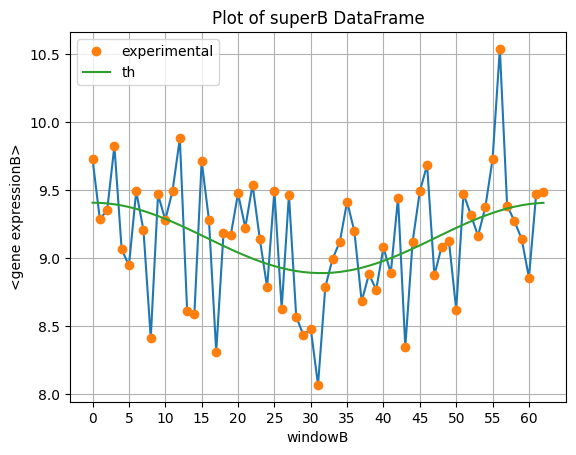

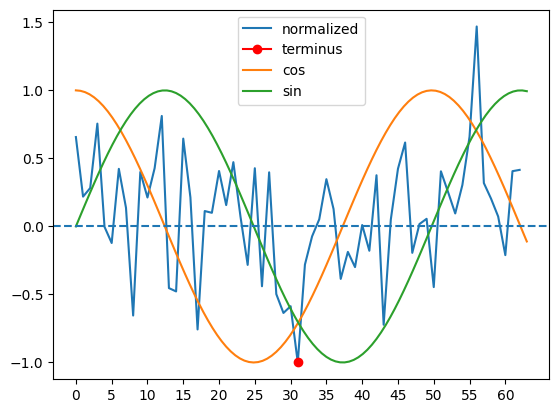

In [337]:
plt.plot(superB.index, superB['<gene expressionB>'])
#plt.plot(super["window"], super["<gene expression>"], alpha= 0.5, color= "red")
plt.xlabel('windowB')
plt.ylabel('<gene expressionB>')
plt.title('Plot of superB DataFrame')
plt.grid(True)
plt.xticks(superB.index[::5])



#fitting
x= pd.DataFrame(data=superB, columns= ["cosB"])
model = LinearRegression().fit(x, superB["<gene expressionB>"])
y_prediction= model.predict(x)  #y value
model.score(x,  superB["<gene expressionB>"])  #R^2
#plt.plot( superB["cosB"], y_prediction, label= "cos vs prediction")
plt.plot(superB.index, superB["<gene expressionB>"], label="experimental", linestyle= "none", marker= 'o')
plt.plot(superB.index, y_prediction, label= "th")
plt.legend()
plt.show()

value= np.linspace(0, 63, 100)
plt.plot(superB.index, superB["normalize"], label= "normalized")
plt.plot(31, -1, marker='o', color="red", label= "terminus")
plt.plot(value, np.cos(value*10), label="cos")
plt.plot(value, np.sin(value*10), label= "sin")
plt.axhline( y=0, linestyle='--')
plt.legend()
plt.xticks(superB.index[::5])
plt.show()




In [335]:
terminus = 8.067340
superB["normalize"] = superB ["<gene expressionB>"] - (terminus+1)
superB.iloc[31]

#hshhhhh


<gene expressionB>    8.067340
cosB                 -0.999135
normalize            -1.000000
Name: 31, dtype: float64

In [ ]:
#usa la funzione/vettorializza togliendo il 1st loop/ rimuovi beta normalizzando: togliendo il fitting dall'ultimo dataframe
#non puoi usare pcs perché abbiamo parametri diversi tra i dati del df (growth rate e n repliche)
#Ass = 2^D+C/tau + f(T, r)/gamma  : ass valori del df in log = espresisone genica rate. 1st: ruolo della rpelicazione in base alla posizione 
#+ 2nd ruolo della regolaizone. quando sottraggo i fitting, ottengo: ass - 2^ = ruolo della regolaizone